In [1]:
import gym
from gym import spaces
import or_gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from or_gym.utils.env_config import *
from or_gym.algos.rl_utils import *
%matplotlib inline

In [7]:
env = or_gym.make('PortfolioOpt-v0')

In [8]:
for i in range(10):
    action = env.action_space.sample()
    s, r, _, done = env.step(action)

In [52]:
class POEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self.num_assets = 1
        self.initial_cash = 100
        self.cash = copy.copy(self.initial_cash)
        self.buy_cost = np.array([0.045, 0.025, 0.035])
        self.sell_cost = np.array([0.04, 0.02, 0.03])
        self.step_limit = 10
        self.asset_price_means = np.ones(self.num_assets) * 10
        self.asset_price_var = np.ones(self.num_assets) * 0.25
        assign_env_config(self, kwargs)
        self.reset()
        # Cash on hand, asset prices, num of shares, portfolio value
        self.obs_length = 1 + 2 * self.num_assets
        self.observation_space = spaces.Box(-0.001, 10000, shape=(self.obs_length,))
        self.action_space = spaces.Box(-1, 1, shape=(self.num_assets,))
        
    def reset(self):
        self.step_count = 0
        self.asset_prices = self._generate_asset_prices()        
        self.holdings = np.zeros(self.num_assets)
        self.cash = copy.copy(self.initial_cash)
        self.last_portfolio_value = copy.copy(self.initial_cash)
        self.state = np.hstack([
            self.initial_cash,
            self.asset_prices[self.step_count],
            self.holdings])
        return self.state
    
    def _generate_asset_prices(self):
        asset_prices = np.vstack([
            np.random.normal(mu, sig, self.step_limit) 
            for mu, sig in zip(self.asset_price_means, self.asset_price_var)])
        # Zero out negative asset prices and all following prices - implies
        # equity is bankrupt and worthless.
        zero_vals = np.vstack(np.where(asset_prices<0))
        cols = np.unique(zero_vals[0])
        for c in cols:
            first_zero = zero_vals[1][np.where(zero_vals[0]==c)[0].min()]
            asset_prices[c,first_zero:] = 0
        return asset_prices.T.round(3)
    
    def step(self, action):
        assert self.action_space.contains(action)
        # Normalize actions to sum to 1
        if sum(action) > 1:
            action = action / action.sum()
        asset_prices = self.asset_prices[self.step_count].copy()
        portfolio_value = np.dot(asset_prices, self.holdings) + self.cash
        for idx, a in enumerate(action):
#             if asset_prices[idx] == 0:
#                 # Asset is worthless
                
            if a == 0:
                continue
            # Sell a shares of asset
            elif a < 0:
                shares_to_sell = np.floor(asset_prices[idx] / 
                    np.abs(a) * portfolio_value)
                if shares_to_sell > self.holdings[idx]:
                    shares_to_sell = self.holdings[idx].copy()
                price = asset_prices[idx] * shares_to_sell * (1 - self.sell_cost[idx])
                self.cash += asset_prices[idx] * shares_to_sell * (1 - self.sell_cost[idx])
                self.holdings[idx] -= shares_to_sell
                
            # Buy a shares of asset
            elif a > 0:
                shares_to_buy = np.ceil(a * portfolio_value * (1 - self.buy_cost[idx])/ asset_prices[idx])
                purchase_cost = asset_prices[idx] * shares_to_buy * (1 + self.buy_cost[idx])
                if self.cash < purchase_cost:
                    shares_to_buy = np.floor(self.cash * (1 - self.buy_cost[idx]) /
                                             asset_prices[idx])
                    purchase_cost = asset_prices[idx] * shares_to_buy * (1 + self.buy_cost[idx])
                self.holdings[idx] += shares_to_buy
                self.cash -= purchase_cost
                
        # Return total portfolio value as reward
        portfolio_value = np.dot(asset_prices, self.holdings) + self.cash
#         reward = portfolio_value - self.last_portfolio_value
        self.last_portfolio_value = copy.copy(portfolio_value)
        reward = portfolio_value / self.initial_cash - 1
        self.step_count += 1
        if self.step_count >= self.step_limit:
            done = True
        else:
            self._update_state()
            done = False
            
        return self.state, reward, done, {}
    
    def _update_state(self):
        self.state = np.hstack([
            self.cash,
            self.asset_prices[self.step_count],
            self.holdings
        ])

In [46]:
env = POEnv()
for i in range(1000):
    s = env.reset()
    done = False
    states, rewards, actions = [], [], []
    t = 0
    while done == False:
        action = env.action_space.sample()
        s, r, done, _ = env.step(action)
        valid_state = env.observation_space.contains(s)
        if not valid_state:
            raise ValueError("Invalid observation state:\n{}".format(s))
        actions.append(action)
        states.append(s)
        rewards.append(r)
        t += 1

In [2]:
import ray
from ray.rllib import agents
from copy import deepcopy
import time
ray.init(ignore_reinit_error=True)

2020-06-05 06:45:28,441	INFO resource_spec.py:212 -- Starting Ray with 5.81 GiB memory available for workers and up to 2.91 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-05 06:45:28,856	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.0.11',
 'raylet_ip_address': '192.168.0.11',
 'redis_address': '192.168.0.11:24548',
 'object_store_address': '/tmp/ray/session_2020-06-05_06-45-28_438744_21962/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-05_06-45-28_438744_21962/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-05_06-45-28_438744_21962'}

In [5]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=50, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, 
            env=create_env('Knapsack-v0'))
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [6]:
config_dict = {'grad_clip': 10}
trainer, results = train_agent(config_dict={})

2020-06-05 07:34:28,703	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-06-05 07:34:28,855	INFO trainable.py:217 -- Getting current IP.
2020-06-05 07:34:28,858	WARNING util.py:37 -- Install gputil for GPU system monitoring.


NotImplementedError: Got <class 'list'>, but expected numpy array or torch tensor.

In [ ]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

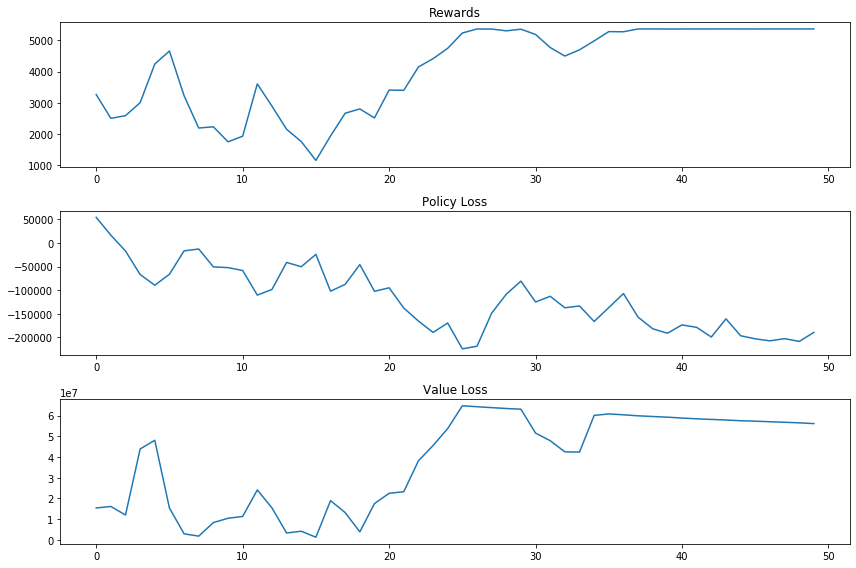

In [17]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

# Run trained algorithm

In [63]:
env = POEnv()
s = env.reset()
for i in range(10):
    action = trainer.compute_action(s)
    s, r, done, _ = env.step(action)
    print(action, r)
    if done:
        break

[-1.] 0.0
[-1.] 0.0
[-1.] 0.0
[-1.] 0.0
[1.] -0.04076729999999995
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013
[-1.] -0.11052810000000013


In [21]:
np.vstack([np.arange(10).reshape(1, -1), np.zeros((2, 10))])

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [22]:
env.state

array([344.70841909,  10.        ,  10.        ,  10.        ,
        23.0501508 ,  12.06007514,   3.16946848])

In [7]:
def _create_env(env_name):
    return or_gym.make(env_name)

In [12]:
def train_agent(env_name, algo='a3c', iters=50, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, 
            env=env_name)
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [13]:
trainer, results = train_agent('CartPole-v0')

2020-06-05 07:43:59,350	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-06-05 07:43:59,498	INFO trainable.py:217 -- Getting current IP.
2020-06-05 07:43:59,500	WARNING util.py:37 -- Install gputil for GPU system monitoring.


NotImplementedError: Got <class 'list'>, but expected numpy array or torch tensor.